In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import keras as k
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
%matplotlib inline

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

from subprocess import check_output
train = pd.read_json('../input/train.json')
# test = pd.read_json('../input/test.json')
print(train.columns)

# Any results you write to the current directory are saved as output.

Using TensorFlow backend.


Index(['band_1', 'band_2', 'id', 'inc_angle', 'is_iceberg'], dtype='object')


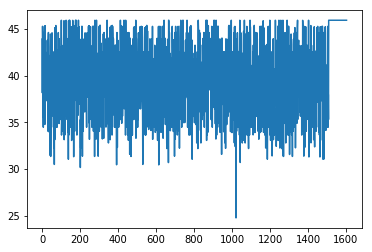

In [2]:
inc_angles = train.copy()['inc_angle']
for i in range(len(inc_angles)):
    if inc_angles[i] == "na":
        inc_angles[i] = 0
# print(inc_angles)


inc_angle_max = max(inc_angles)
for i in range(len(inc_angles)):
    if inc_angles[i] == 0:
        inc_angles[i] = inc_angle_max
        
plt.plot(inc_angles)

7.64266661445
-0.213149
-38.211376


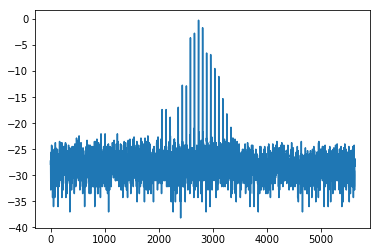

In [3]:
t = np.array(train['band_1'][0])
var = np.var(t)
print(var)
print(t.max())
print(t.min())
plt.plot(t)

In [4]:
df = train['band_1'][0]
a = np.array(df)
print(np.absolute(a))

[ 27.878361  27.15416   28.668615 ...,  26.817032  27.881983  28.268127]


In [5]:
def band_to_images(df):
    images = []
    lmd = 3 # affects the threshold 
    alpha = 0.1
    inc_angles = df.copy()['inc_angle']
    
    for i in range(len(inc_angles)):
        if inc_angles[i] == "na":
            inc_angles[i] = 0

    inc_angle_max = max(inc_angles)
    for i in range(len(inc_angles)):
        if inc_angles[i] == 0:
            inc_angles[i] = inc_angle_max
    
    for x in df.index:
        band_1 = np.array(df.loc[x].band_1)
        band_2 = np.array(df.loc[x].band_2)
        
        band_1_var = np.var(band_1)
        band_2_var = np.var(band_2)
        band_1_max = np.max(band_1)
        band_2_max = np.max(band_2)
        band_1_min = np.min(band_1)
        band_2_min = np.min(band_2)
        distance_min_max_b1 = band_1_max - band_1_min
        distance_min_max_b2 = band_2_max - band_2_min
        band_1_threshold = band_1_max - lmd*band_1_var
        band_2_threshold = band_2_max - lmd*band_2_var
        
        
        
        for i in range(band_1.shape[0]):
            if band_1[i] < band_1_threshold:
                band_1[i] = band_1[i] - alpha * (np.cos(inc_angles[x]) - np.cos(inc_angle_max)) * \
                    distance_min_max_b1/(band_1_max - band_1[i]) * band_1_var
        
        for i in range(band_2.shape[0]):
            if band_2[i] < band_2_threshold:
                band_2[i] = band_2[i] - alpha * (np.cos(inc_angles[x]) - np.cos(inc_angle_max)) * \
                    distance_min_max_b2/(band_2_max - band_2[i]) * band_2_var
        
#         band_1 = np.array(df.loc[x].band_1).reshape(75, 75)
#         band_2 = np.array(df.loc[x].band_2).reshape(75, 75)
        band_1 = band_1.reshape(75, 75)
        band_2 = band_2.reshape(75, 75)
        
        band_3 = (band_1 + band_2)/2
        band_4 = band_1 - band_2 # ... was divide
        band_1_scale = (band_1-band_1.mean())/(band_1.max()-band_1.min())
        band_2_scale = (band_2-band_2.mean())/(band_2.max()-band_2.min())
        band_3_scale = (band_3-band_3.mean())/(band_3.max()-band_3.min())
        band_4_scale = (band_4-band_4.mean())/(band_4.max()-band_4.min())
        images.append(np.dstack((band_1_scale, band_2_scale, band_3_scale, band_4_scale)))
    return np.array(images)

# 
def data_augment(images):
    lr_images = []
    ud_images = []
    for x in range(0, images.shape[0]):
        band_1 = images[x, :, :, 0]
        band_2 = images[x, :, :, 1]
        band_3 = images[x, :, :, 2]
        band_4 = images[x, :, :, 3]
        # lr augment
        band_1_lr = np.fliplr(band_1)
        band_2_lr = np.fliplr(band_2)
        band_3_lr = np.fliplr(band_3)
        band_4_lr = np.fliplr(band_4)
        lr_images.append(np.dstack((band_1_lr, band_2_lr, band_3_lr, band_4_lr)))
        #ud augment
        band_1_ud = np.flipud(band_1)
        band_2_ud = np.flipud(band_2)
        band_3_ud = np.flipud(band_3)
        band_4_ud = np.flipud(band_4)
        ud_images.append(np.dstack((band_1_ud, band_2_ud, band_3_ud, band_4_ud)))
    lr_images = np.array(lr_images)
    ud_images = np.array(ud_images)
    images = np.concatenate((images, ud_images, lr_images))
    return images

In [6]:
x_train = band_to_images(train)
x_train = data_augment(x_train)
y_train = train.is_iceberg
y_train = np.concatenate((y_train, y_train, y_train))
# x_test = band_to_images(test)
# idno_test = test.id

In [7]:
model = k.models.Sequential()
# conv1
model.add(k.layers.convolutional.Conv2D(64, kernel_size=(3, 3), activation='relu', input_shape=(75, 75, 4)))
model.add(k.layers.convolutional.MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))
model.add(k.layers.Dropout(0.2))
#conv2
model.add(k.layers.convolutional.Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(k.layers.convolutional.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(k.layers.Dropout(0.2))
#conv3
model.add(k.layers.convolutional.Conv2D(128, kernel_size=(3, 3), activation='relu' ))
model.add(k.layers.convolutional.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(k.layers.Dropout(0.2))
# conv4
model.add(k.layers.convolutional.Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(k.layers.convolutional.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(k.layers.Dropout(0.2))
# # fc1
# model.add(k.layers.Flatten())
# model.add(k.layers.Dense(512))
# model.add(k.layers.Activation('relu'))
# model.add(k.layers.Dropout(0.5))
#fc2
model.add(k.layers.Flatten())
model.add(k.layers.Dense(256))
model.add(k.layers.Activation('relu'))
model.add(k.layers.Dropout(0.5))
#output
model.add(k.layers.Dense(1))
model.add(k.layers.Activation('sigmoid'))

model.compile(loss='binary_crossentropy', optimizer=k.optimizers.Nadam(0.001), metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 73, 73, 64)        2368      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 128)       147584    
__________

In [8]:
early_stopping = EarlyStopping(monitor='val_loss', patience=4)

# validation split won't shuffle the data!
model.fit(x_train, y_train, batch_size=64, epochs=10, verbose=1, validation_split=0.2, callbacks=[early_stopping])
# pred_test = model.predict(x_test)
# submission = pd.DataFrame({'id': idno_test, 'is_iceberg': pred_test.reshape((pred_test.shape[0]))})
# submission.to_csv('cnn_keras.csv', index=False)

Train on 3849 samples, validate on 963 samples
Epoch 1/10
3849/3849 [==============================] - 11s - loss: 0.6516 - acc: 0.5898 - val_loss: 1.0378 - val_acc: 0.4382
Epoch 2/10
3849/3849 [==============================] - 9s - loss: 0.6156 - acc: 0.6625 - val_loss: 0.7192 - val_acc: 0.5151
Epoch 3/10
3849/3849 [==============================] - 9s - loss: 0.4778 - acc: 0.7599 - val_loss: 0.4528 - val_acc: 0.7840
Epoch 4/10
3849/3849 [==============================] - 8s - loss: 0.3885 - acc: 0.8246 - val_loss: 0.4524 - val_acc: 0.7726
Epoch 5/10
3849/3849 [==============================] - 9s - loss: 0.3521 - acc: 0.8345 - val_loss: 0.9905 - val_acc: 0.6739
Epoch 6/10
3849/3849 [==============================] - 9s - loss: 0.3159 - acc: 0.8618 - val_loss: 0.3147 - val_acc: 0.8598
Epoch 7/10
3849/3849 [==============================] - 9s - loss: 0.2735 - acc: 0.8826 - val_loss: 0.3126 - val_acc: 0.8650
Epoch 8/10
3849/3849 [==============================] - 9s - loss: 0.2542 - a

In [9]:
# result = pd.read_csv('cnn_keras.csv')

In [10]:
# result['is_iceberg'] = result['is_iceberg'].apply(lambda x: x > 0.5)

In [11]:
# result.head()